# カスタムタスク作成ノートブック

## セットアップ

### ライブラリのインポート

In [1]:
import datarobot as dr
from datarobot.models.execution_environment import ExecutionEnvironment

from datarobot_bp_workshop import Workshop, Visualize
from datarobot_bp_workshop.magic import *

### DataRobotに接続する

[クライアントからDataRobotに接続する](https://docs.datarobot.com/ja/docs/api/api-quickstart/index.html)ためのさまざまなオプションの詳細をご確認ください。


In [2]:
with open('../api.token', 'r') as f:
    token = f.read()
    dr.Client(token=token, endpoint='https://app.datarobot.com/api/v2')

## ブループリントワークショップの初期化

In [3]:
w = Workshop()

Sklearnドロップイン環境の取得


In [4]:
environments = ExecutionEnvironment.list()

In [5]:
scikit_env = environments[7]

In [6]:
customr = w.create_custom_task(
    environment_id=scikit_env.id,
    name="My Custom Ridge Regressor w/ Imputation",
    target_type="Regression",
    description="Impute values and perform ridge regression."
)
# customr = w.get_custom_task('608e5bc8b66a4934d58d0d4e')

## カスタムモデルの反復処理

In [7]:
%%update_custom {customr.id}
import pickle
import numpy as np
import pandas as pd

from typing import List, Optional
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


def fit(
    X: pd.DataFrame,
    y: pd.Series,
    output_dir: str,
    class_order: Optional[List[str]] = None,
    row_weights: Optional[np.ndarray] = None,
    **kwargs,
):
    numeric_transformer = ColumnTransformer(
        transformers=[
            (
                "imputer",
                SimpleImputer(strategy="median", add_indicator=True),
                make_column_selector(dtype_include=np.number),
            )
        ]
    )
    pipeline = Pipeline(steps=[("numeric", numeric_transformer), ("model", Ridge())])
    
    pipeline.fit(X, y)
    
    with open("{}/artifact.pkl".format(output_dir), "wb") as fp:
        pickle.dump(pipeline, fp)

'608ef74c5dda651931052422'

In [10]:
custom_ridge = w.CustomTask(customr.id)(w.TaskInputs.NUM)
custom_ridge_bp = w.BlueprintGraph(custom_ridge, name="My Inline Custom Blueprint")

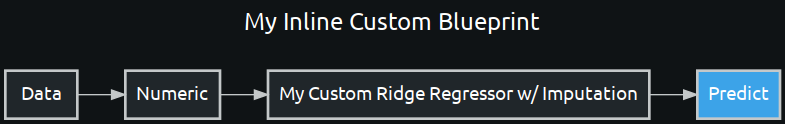

In [11]:
custom_ridge_bp.show()

In [12]:
custom_ridge_bp.save()

Name: 'My Inline Custom Blueprint'

Input Data: Numeric
Tasks: My Custom Ridge Regressor w/ Imputation

In [13]:
custom_ridge_bp.train('5eb9656901f6bb026828f14e')

Name: 'My Inline Custom Blueprint'

Input Data: Numeric
Tasks: My Custom Ridge Regressor w/ Imputation